In [2]:
import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
x, y = make_classification(n_samples=1000, n_features=10, random_state=42, n_classes=2)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42)

**tf.data API for Performance**

- Creating Efficient Data Pipelines:

In [4]:
def create_tf_dataset(images, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)


train_dataset = create_tf_dataset(x_train, y_train, batch_size=32)
val_dataset = create_tf_dataset(x_test, y_test, batch_size=32, shuffle=False)

- Data Augmentation with tf.data:

In [5]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

**Mixed Precision Training**

- Enabling Mixed Precision:

In [6]:
from tensorflow.keras.mixed_precision import set_global_policy

# Set mixed precision policy
set_global_policy('mixed_float16')


# Build model (will automatically use mixed precision)
model = keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax', dtype='float32')
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Functional API vs Sequential API**

In [8]:
# Sequential API:
sequential_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(784,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])


# Functional API:
inputs = layers.Input(shape=(784,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)
functional_model = keras.Model(inputs=inputs, outputs=outputs)


# Multi-input example
input1 = layers.Input(shape=(784,), name='image')
input2 = layers.Input(shape=(10,), name='metadata')
x1 = layers.Dense(64, activation='relu')(input1)
x2 = layers.Dense(64, activation='relu')(input2)
merged = layers.concatenate([x1, x2])
outputs = layers.Dense(10, activation='softmax')(merged)
multi_input_model = keras.Model(inputs=[input1, input2], outputs=outputs)

**Advanced Transfer Learning: Fine-Tuning**

- Fine-Tuning Strategy:

In [9]:
# Step 1: Feature Extraction (freeze base)
base_model = keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax')
])

# Train feature extraction phase
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [10]:
# Step 2: Fine-Tuning (unfreeze some layers)
base_model.trainable = True

# Freeze early layers, fine-tune later layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Use lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Model Evaluation and Debugging**

- Visualizing Model Architecture:

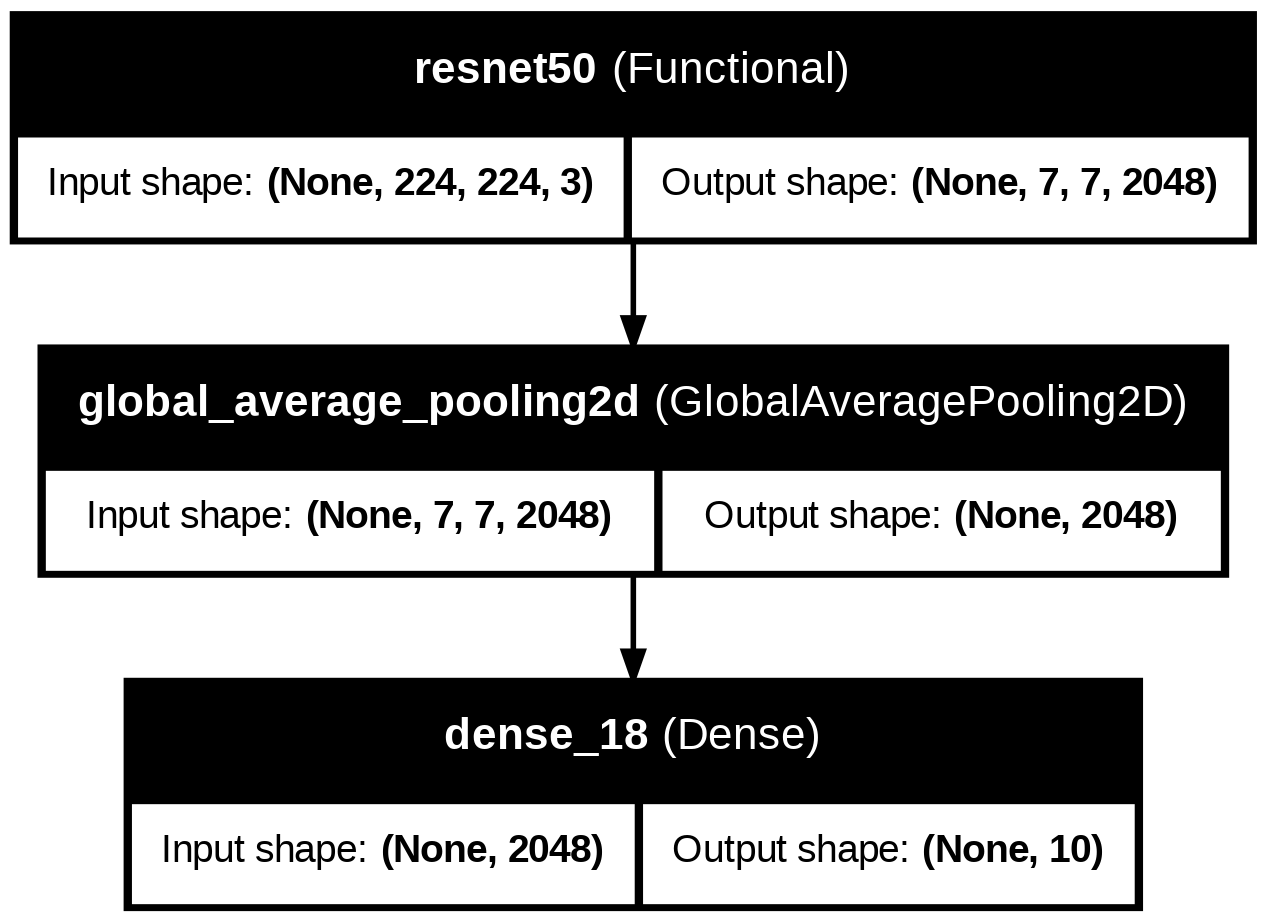

In [11]:
keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

In [13]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 4,486,154 (17.11 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

- Inspecting Model Predictions:

In [16]:
import matplotlib.pyplot as plt

# Get intermediate layer outputs
intermediate_model = keras.Model(
    inputs=model.input,
    outputs=model.get_layer('dense_1').output
)
intermediate_output = intermediate_model.predict(x_test[:10])


# Visualize predictions
def plot_predictions(y_true, y_pred, samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(samples):
        axes[i].imshow(x_test[i], cmap='gray')
        axes[i].set_title(f'True: {y_true[i]}\nPred: {np.argmax(y_pred[i])}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(y_test[:10], predictions[:10])

**TensorFlow Datasets (TFDS)**

In [ ]:
import tensorflow_datasets as tfds

# Load dataset
(ds_train, ds_test), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Preprocess
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (224, 224))
    return image, label

ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32)